**Project  intro**

This project aims to improve ML prediction accuracy by error shaping. We will focus on accuracy and traffic data. This implies we will not be concerned too much with the architecture, computing time or task type.


**Motivation**

Models that gained so much attention in the past several years crowded in image processing and natual language processing area because of their application value. Now think about what is in common among all these starring models: deep SORT, YOLO3, SSD, Fast/Faster RCNN, BERT, Transformer? The answer is: they are all point-estimate, they are over confident by ignoring the information of prediction cofidence. The model is forced to make a prediction even when it is facing some never seen data. Let's say your object detection model can recognize cars, trucks, pedestrian, traffic light and street signs. Then you sold this well trained model to some company in UK, and then the model behaves badly. Guess why? because the model never seen a monted police! Please note the prediction confidence is not same as the probabilities from the softmax layer. Those probabilities are calculated given the assumption that the possible result is included in the given classes. 


This "confidence ignorance" is a big problem for many areas. The most interesting one to me is day trading. As a day trader or scalper, you start by building the watch list of the equities or forexes that you belive will have the highest valotility of the day. Let's say you are a ML practitioner, you want to systematically optimize this one instead of doing subjective trading. You can easily predict the share, colume or even price for the 10k stocks in the US market with all the fancy APIs availabel nowadays, but how to decided which tickers to focus on? Here comes the prediction interval. Although the primary drive for this research project is in trasportation area, its potential application in trading and finance captivates me a lot. 

**Background**

Prediction uncertainty can be classified into epistemic uncertainty and aleatoric uncertainty which are reflected from model noise and predicton noise respectively. As the name suggested, epistemic uncertainty stems from the lack of knowledge, it can be reduced by learning from more data, it is also called reducible uncertainty. While aleatoric uncertainty comes from the intrinsic noise of data itself, it can not be reduced by collecting more data, it is also called irreducible uncertainty. 

For epistemic uncertainty, it has further two resources: the uncertainty of the model and the uncertainty of the parameters of a given model. This can be simulated by incorprating the prior disitrubution of model parameters. Natually, these models are called Bayesian neural networks. 

Another concept should be clarified for this project: the difference between confidence interval(CI) and predictive interval(PI)

(unfinished)

**Experiment design**

Our only assumption for this proposal is that the intrinsic noise from data follows normal distribution which is not an strong assumption for most situations. 

(unfinished)

## 1. Get to know the data and the task

As a machine learning practitioner, you should always try to gain some level of understanding for your data and task first. We use this dataset simply because is clean and easy to handle. It's nice to learn what decides the Mile Per Hour of your car too. 

#### The dataset is from UCI Machine Learning Repository, more description can be found [here](https://archive.ics.uci.edu/ml/datasets/Auto+MPG):


In [65]:
!pip install q keras==2.0.3
!pip show keras
!pip show tensorflow
!pip install -q seaborn

Name: Keras
Version: 2.0.3
Summary: Deep Learning for Python
Home-page: https://github.com/fchollet/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, theano, pyyaml
Required-by: 
Name: tensorflow
Version: 1.14.0rc1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, numpy, gast, absl-py, astor, six, protobuf, keras-preprocessing, tensorflow-estimator, wrapt, grpcio, wheel, termcolor, tensorboard, google-pasta
Required-by: stable-baselines, magenta, fancyimpute


In [66]:
from __future__ import absolute_import, division, print_function
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
import tensorflow as tf 

print(keras.__version__)
print(tf.__version__)

2.0.3
1.14.0-rc1


The deault version of `Keras` in Colab is 2.2.4, but I can not find its documentation, so I installed `Keras` 2.0.3 at the begining of this notebook.

In [67]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [68]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
print(dataset.groupby('Cylinders').nunique())
print(dataset.groupby('Origin').nunique())
dataset.tail()

           MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
Cylinders                                ...                                  
3            4          1             2  ...             2           4       1
4           87          1            44  ...            74          13       3
5            3          1             3  ...             3           3       1
6           38          1            18  ...            39          12       3
8           27          1            19  ...            35          11       1

[5 rows x 8 columns]
        MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
Origin                                ...                                  
1        82          3            48  ...            75          13       1
2        42          3            30  ...            43          13       1
3        54          3            25  ...            42          13       1

[3 rows x 8 columns]


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [0]:
dataset.isna().sum()
dataset = dataset.dropna()

After checking and fixing the missing values, we now need to convert categorical features **`Cylinders`** and **`Origin`**  into one hot vectors.

In [70]:

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


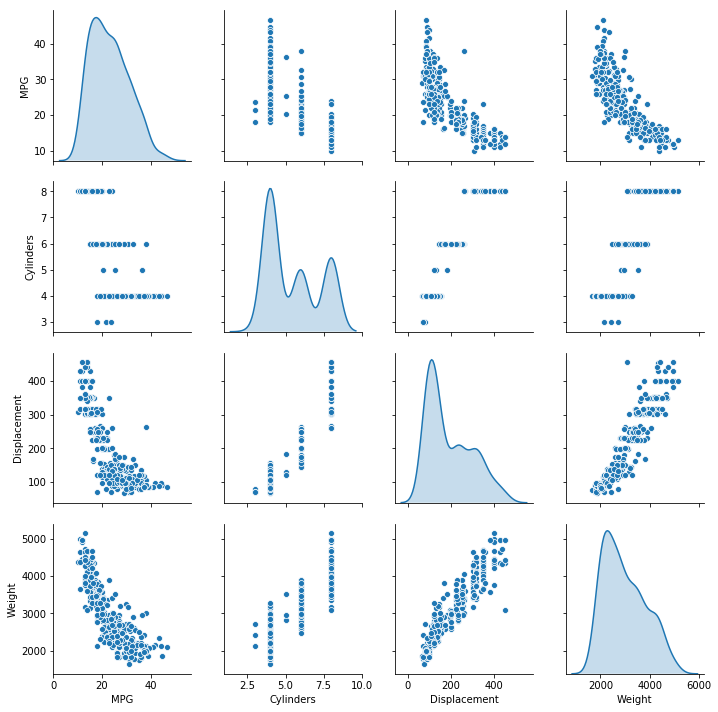

In [71]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [73]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

def build_model():
  model = Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam()
  #optimizer = optimizers.adam(lr=0.001, decay=1e-6)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [74]:
type(normed_train_data.values)

numpy.ndarray

`normed_train_data` and `train_labels` are `pandas.core.frame.DataFrame`, but `keras.model.fit()` only accepts `numpy.ndarray`. This is handled by the  attribute `.values` of `DataFram`.

In [75]:
history = model.fit(
  normed_train_data.values, train_labels.values,
  epochs=1000, validation_split = 0.1, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,10.994915,2.477650,10.994915,1.935156,0.918289,1.935156,995
996,11.761974,2.549982,11.761974,1.976435,0.898838,1.976435,996
997,10.661307,2.406627,10.661307,1.995471,0.928021,1.995471,997
998,11.051876,2.495420,11.051876,1.960346,0.899259,1.960346,998
999,11.365471,2.511730,11.365471,1.940769,0.921488,1.940769,999


In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  y_max = max(hist['val_mean_absolute_error'])
  plt.ylim([0,y_max])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  y_max = max(hist['val_mean_squared_error'])
  plt.ylim([0,y_max])
  plt.legend()
  plt.show()

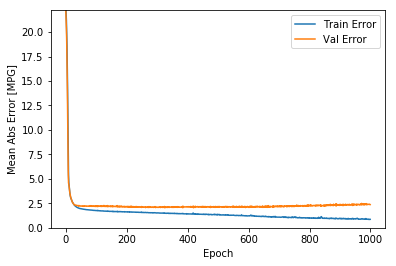

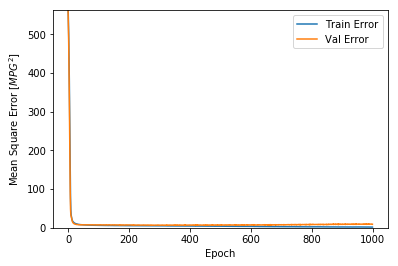

In [0]:
plot_history(history)

Notice that the above plots may look quite different if you run this code several times. The reason is that, in function `plot_history`, the limit of y_axis is decided by the maximum value of errors. If the initializer happens to give you a bad starting point, then the plot will be squished down quite a bit. However, if it starts from not too bad position, the plot can be much more expanded and readable. Just pay attention to the scale of your y_axis. Same reason applies to the plots below. 

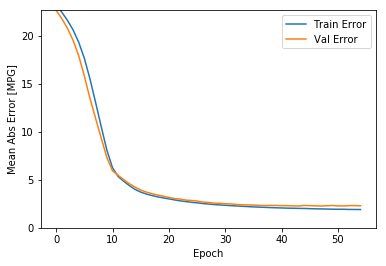

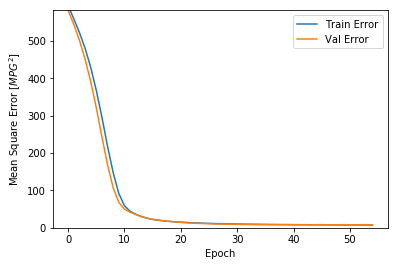

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data.values, train_labels.values, epochs=1000,
                    validation_split = 0.1, verbose=0, callbacks=[early_stop])

plot_history(history)

In [0]:
loss, mae, mse = model.evaluate(normed_test_data.values, test_labels.values, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.81 MPG


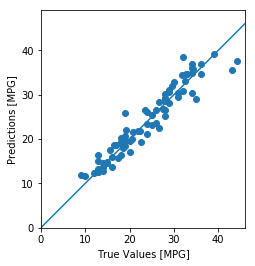

In [0]:
test_predictions = model.predict(normed_test_data.values).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

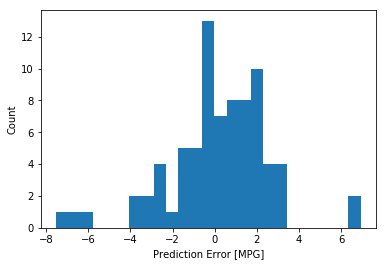

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

After getting yourself familiarized with the dataset and the naive model, let us now focus on loss function. We will compare two models where the only difference is their loss function.To make the code more flexible and meaningful for future use, I will use Keras functional API this time, but the model strcuture is exactly same as the above one built with `Keras.sequential()`.

Although the idea that we expect the new loss function to improve the accuracy is straightforward, the implementation is a lot more tricky if you realized that `callbacks`, `losses`, `history` do not offer API for accessing `loss` of each past batch for functional models while training. 

## 2. Build the target model



In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping
import numpy as np

`LossHistory.losses` has to be initialized, because `on_train_begin` won't be called until `.fit` which means `.losses` won't exist while `.compile`. This will fail `.compile`. 

In [0]:
class LossHistory(Callback):
  def __init__(self):
    self.losses = []
  def on_train_begin(self, logs={}):
    self.losses = []

  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))

In [0]:
def custom_loss(hist):
#a, b are list of same length
  def KL(a, b):
      a = np.asarray(a, dtype=np.float)
      b = np.asarray(b, dtype=np.float)
      return np.sum(np.where(a != 0, a * np.log(a / b), 0))

  
  def normalKL(loss_hist_list):
    loss_hist_normal_list = np.random.normal(size=len(loss_hist_list))
    return KL(loss_hist_list, loss_hist_normal_list)

  loss_hist_list = hist.losses
  weight = 0.001
  
  def errorShape_loss(y_true, y_pred):
    mse = keras.losses.mean_squared_error(y_true, y_pred)
    distribution_loss = normalKL(loss_hist_list)
    return mse + weight*distribution_loss

  return errorShape_loss

In [0]:
def build_model_dist():
  input = Input(shape=[len(train_dataset.keys())])
  x = Dense(64, activation='relu', name="dense1")(input)   
  x = Dense(64, activation='relu', name="dense2")(x)
  #output = Dense(1, activation='sigmoid', name='output')(x)
  output = Dense(1, name='output')(x)
  model = Model(input=[input], output=[output])
  optimizer = keras.optimizers.Adam()
  h = LossHistory()
  
  model.compile(loss=custom_loss(h), 
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'],
                callbacks = h)
  return model


def build_model_base():
  input = Input(shape=[len(train_dataset.keys())])
  x = Dense(64, activation='relu', name="dense1")(input)   
  x = Dense(64, activation='relu', name="dense2")(x)
  #output = Dense(1, activation='sigmoid', name='output')(x)
  output = Dense(1, name='output')(x)
  model = Model(input=[input], output=[output])
  optimizer = keras.optimizers.Adam()

  model.compile(loss='mean_squared_error', 
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [82]:
def build_model():
  model = Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam()
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [83]:
model_dist = build_model_dist()
model_dist.summary()
model_base = build_model_base()
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                640       
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense1 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2124: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2124: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


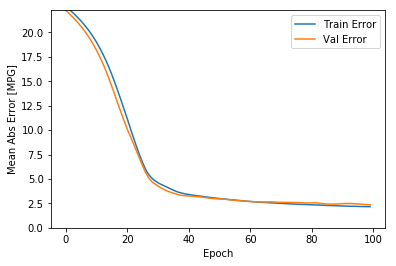

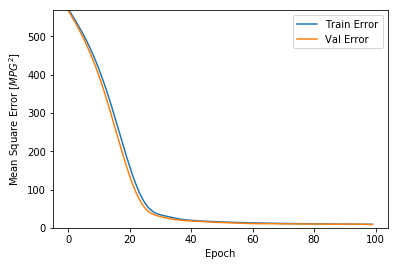

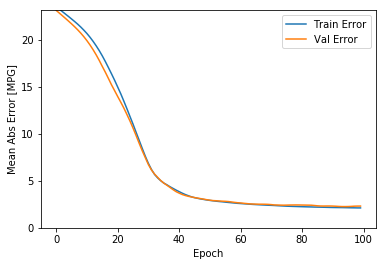

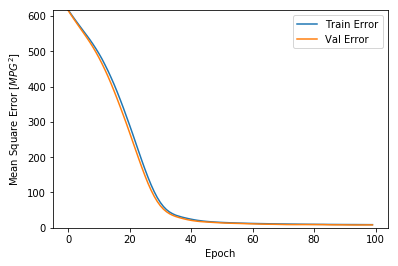

In [84]:
his_dist = model_dist.fit(normed_train_data.values, train_labels.values,
          batch_size=128,
          validation_split = 0.1,
          epochs = 100,
          verbose=0)
plot_history(his_dist)

his_base = model_base.fit(normed_train_data.values, train_labels.values,
          batch_size=128,
          validation_split = 0.1,
          epochs = 100,
          verbose=0)
plot_history(his_base)

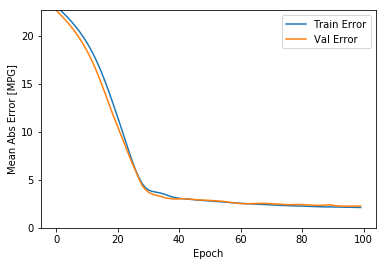

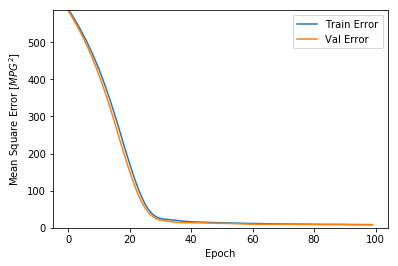

In [85]:
his_seq = model.fit(normed_train_data.values, train_labels.values,
          batch_size=128,
          validation_split = 0.1,
          epochs = 100,
          verbose=0)
plot_history(his_seq)

In [86]:
loss, mae, mse = model.evaluate(normed_test_data.values, test_labels.values, verbose=0)
print(".Sequential()-model: Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
loss, mae, mse = model_base.evaluate(normed_test_data.values, test_labels.values, verbose=0)
print(".Model()-model_base: Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
loss, mae, mse = model_dist.evaluate(normed_test_data.values, test_labels.values, verbose=0)
print(".Model()-model_dist: Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

.Sequential()-model: Testing set Mean Abs Error:  1.98 MPG
.Model()-model_base: Testing set Mean Abs Error:  1.98 MPG
.Model()-model_dist: Testing set Mean Abs Error:  1.95 MPG


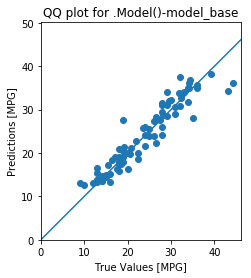

In [93]:
test_predictions = model_base.predict(normed_test_data.values).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.title("QQ plot for .Model()-model_base")
_ = plt.plot([-100, 100], [-100, 100])

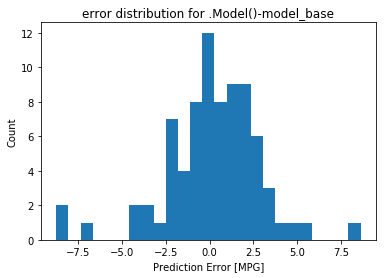

In [92]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.title("error distribution for .Model()-model_base")
_ = plt.ylabel("Count")


/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2124: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


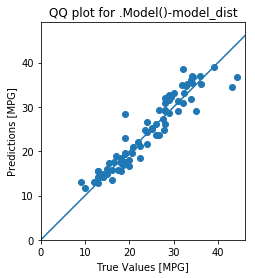

In [94]:
test_predictions = model_dist.predict(normed_test_data.values).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.title("QQ plot for .Model()-model_dist")
_ = plt.plot([-100, 100], [-100, 100])


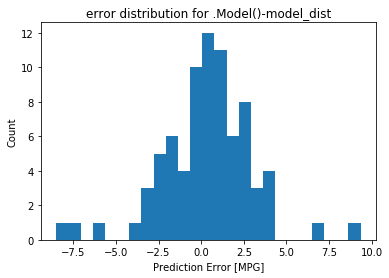

In [96]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.title("error distribution for .Model()-model_dist")
_ = plt.ylabel("Count")

## 3. Fine tune the target model

Now, we have a benchmark for fine tuning this error shaping model. Models with exact same layers should perform same, the difference between `Sequential()-model` and `.Model()-model_base`should be considered as triaval and provide insight to claim significance of the improvement from `.Model()-model_base` to `.Model()-model_dist`.  That is, when fine tuning and evluate our target model `.Model()-model_dist`, we will always compare it with `.Model()-model_base` claim the improvement by subtracting the stocastic improvement reflected by the difference between `Sequential()-model` and `.Model()-model_base`.

My logic for the model evaluation can be expressed as following:

<img src="http://i68.tinypic.com/xe3in6.png" width="600">

***

Now, let's play with hyper-parameters! I will first try the following combinations for the same structure:

(You can find the difference between Mututal Information and KL Divergence [here](https://en.wikipedia.org/wiki/Mutual_information), MI is more general and equals to the KL distance between the joint distribution and product of the two marginal distributions.)

| Name        | Values to test          | Note |
| ------------- |:-------------:| -----:|
| dist_weight     | 0.01, 0.05, 0.1, 0.2, 0.5, 1 |  |
| dist_type     | MI or KL      |  |



After optimizing dist_weight and dist_type, I will try different architectures to find out the best structure for the target model:


| Name        | Values to test          | Note |
| ------------- |:-------------:| -----:|
| top layer activation function     | linear, sigmoid, tanh, softmax |  |
| layers#      | 2, 3, 5, 10      | the task is too easy |
| nodes | 8, 16, 32, 64, 128, 256      |    |
| dropout | 0-0.6      ||
| batch size | 8, 16, 32, 64, 128, 256      |    |



Hyper-parameters that are ignored to simplify the experiment include:

| Name        |Default           | Note |
| ------------- |:-------------:| -----:|
| naive loss function     | `mae` |  |
| batch normalzation      | not used      |  |
| optimizer | `Adam`      |    |
| initializer | Keras default      | e.g. `glorot_uniform` for `Dense`   |
| epochs | 1000      | `EarlyStopping` is used |

***

Let me make some wrappers for the above code and only offer API for the parameters of interest. 

In [0]:
!pip install q keras==2.0.3
!pip show keras
!pip show tensorflow
!pip install -q seaborn

from __future__ import absolute_import, division, print_function
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from keras.models import Sequential, Model
from keras import layers
from keras.layers import Input, Dense
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping



def prepare_data():
  dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
  column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                  'Acceleration', 'Model Year', 'Origin'] 
  raw_dataset = pd.read_csv(dataset_path, names=column_names,
                            na_values = "?", comment='\t',
                            sep=" ", skipinitialspace=True)
  dataset = raw_dataset.copy()
  dataset.isna().sum()
  dataset = dataset.dropna()
  origin = dataset.pop('Origin')
  dataset['USA'] = (origin == 1)*1.0
  dataset['Europe'] = (origin == 2)*1.0
  dataset['Japan'] = (origin == 3)*1.0
  train_dataset = dataset.sample(frac=0.8,random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
  train_stats = train_dataset.describe()
  train_stats.pop("MPG")
  train_stats = train_stats.transpose()
  train_labels = train_dataset.pop('MPG')
  test_labels = test_dataset.pop('MPG')
  def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
  normed_train_data = norm(train_dataset)
  normed_test_data = norm(test_dataset)
  
  return train_dataset, test_dataset, train_labels, test_labels

In [0]:
# model_name can only be: "seq", "base", "dist"
#default batch_size in Keras is 32
class FineTuner():
  def __init__(self, model_name="dist", dist_type="kl", dist_weight=0.1, batch_size=32, summary=False, plot_history=False, plot_qq=False, plot_dist=False, print_mae=True):
    self.model_name = model_name
    self.dist_type = dist_type
    self.dist_weight = dist_weight
    self.batch_size = batch_size
    self.summary = summary
    self.plot_history = plot_history
    self.plot_qq = plot_qq
    self.plot_dist = plot_dist
    self.print_mae = print_mae
  
    
  def model_seq(self): # include both .compile and .fit
    #build the model
    model = Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)])
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(),
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    # train the model
    history = model.fit(normed_train_data.values, train_labels.values,
                        epochs=1000, validation_split = 0.1, verbose=0, callbacks=[early_stop])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    return model, hist
      
 
  def model_base(self): # include both .compile and .fit
    #build the model
    input = Input(shape=[len(train_dataset.keys())])
    x = Dense(64, activation='relu', name="dense1")(input)   
    x = Dense(64, activation='relu', name="dense2")(x)
    output = Dense(1, name='output')(x)
    model = Model(input=[input], output=[output])

    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    #train the model
    his = model_dist.fit(normed_train_data.values, train_labels.values, 
                         batch_size=self.batch_size,
                         validation_split = 0.1, epochs = 100, verbose=0)
    if self.summary:
      model.summary()
    return model, hist
    
    
  def model_dist(): # include both .compile and .fit
    #build the model
        # customize callbacks to record losses of each batch
    class LossHistory(Callback):
      def __init__(self):
        self.losses = []
      def on_train_begin(self, logs={}):
        self.losses = []

      def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

        # customize loss function to incorporate error distribution information  
    def custom_loss(hist):
        #a, b are list of same length
      def KL(a, b):
          a = np.asarray(a, dtype=np.float)
          b = np.asarray(b, dtype=np.float)
          return np.sum(np.where(a != 0, a * np.log(a / b), 0))

      def normalKL(loss_hist_list):
        loss_hist_normal_list = np.random.normal(size=len(loss_hist_list))
        return KL(loss_hist_list, loss_hist_normal_list)

      loss_hist_list = hist.losses
      weight = self.dist_wright

      def errorShape_loss(y_true, y_pred):
        mse = keras.losses.mean_squared_error(y_true, y_pred)
        distribution_loss = normalKL(loss_hist_list)
        return (1-weight)*mse + weight*distribution_loss

      return errorShape_loss


    input = Input(shape=[len(train_dataset.keys())])
    x = Dense(64, activation='relu', name="dense1")(input)   
    x = Dense(64, activation='relu', name="dense2")(x)
    output = Dense(1, name='output')(x)
    model = Model(input=[input], output=[output])

    h = LossHistory()
    model.compile(loss=custom_loss(h), 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['mean_absolute_error', 'mean_squared_error'],
                  callbacks = h)

    #train the model
    hist = model_dist.fit(normed_train_data.values, train_labels.values, 
                          batch_size=self.batch_size,
                          validation_split = 0.1, epochs = 100, verbose=0)
    if self.summary:
      model.summary()
    return model, hist

  
  def plot_history_actually(self):
    history = self.hist
    #hist = pd.DataFrame(history.history)
    #hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    y_max = max(hist['val_mean_absolute_error'])
    plt.ylim([0,y_max])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    y_max = max(hist['val_mean_squared_error'])
    plt.ylim([0,y_max])
    
    if self.model_name=="seq" or self.model_name =="base":
      title = "QQ plot for " + self.model_name, "dist_type: None, dist_weight: None, batch_size: " + str(self.batch_size)
    elif self.model_name == "dist":
      title = "QQ plot for " + self.model_name + "dist_type:" + self.dist_type, "dist_weight:" + str(self.dist_weight) + ", batch_size: " + str(self.batch_size)
    plt.title(title)
    plt.legend()
    plt.show()
    
  
  
  def plot_qq_actually(self):
    test_predictions = self.model.predict(normed_test_data.values).flatten()

    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    
    if self.model_name=="seq" or self.model_name =="base":
      title = "QQ plot for " + self.model_name, "dist_type: None, dist_weight: None, batch_size: " + str(self.batch_size)
    elif self.model_name == "dist":
      title = "QQ plot for " + self.model_name + "dist_type:" + self.dist_type, "dist_weight:" + str(self.dist_weight) + ", batch_size: " + str(self.batch_size)
    plt.title(title)
    _ = plt.plot([-100, 100], [-100, 100])

  def plot_dist_actually(self):
    test_predictions = self.model.predict(normed_test_data.values).flatten()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error [MPG]")
    if self.model_name=="seq" or self.model_name =="base":
      title = "QQ plot for " + self.model_name, "dist_type: None, dist_weight: None, batch_size: " + str(self.batch_size)
    elif self.model_name == "dist":
      title = "QQ plot for " + self.model_name + "dist_type:" + self.dist_type, "dist_weight:" + str(self.dist_weight) + ", batch_size: " + str(self.batch_size)
    plt.title(title)
    _ = plt.ylabel("Count")
          
  def print_mae_actually(self):
    loss, mae, mse = self.model.evaluate(normed_test_data.values, test_labels.values, verbose=0)
    print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae), "with model:", self.model_name)
 
  
  def result(self):
    if self.model_name == "seq":
      self.model, self.hist = self.model_seq()
    elif self.model_name == "base":
      self.model, self.hist = self.model_base()
    elif self.model_name == "dist":
      self.model, self.hist = self.model_dist()
    else:
      Print("model_name is illegal!")

    if self.plot_history:
      self.plot_history_actually()
    if self.plot_qq:
      self.plot_qq_actually()
    if self.plot_dist:
      self.plot_dist_actually()
    if self.print_mae:
      self.print_mae_actually()

In [0]:
Experiment design:


Experiment design and result:

| No.        | dist_type          | dist_weight | model | repeat| mean mae| means|
| ------------- |:-------------:| -----:|-----:| ----:|----:|----:|
| 0     | None | None | seq | 3| 1.83 | 1.85, 1.82, 1.82|
| 1     | None | None | base |3|
| 2     | KL | 0.01 | dist |3|
| 3     |  KL | 0.1 | dist|3|
| 4     |  KL | 0.5 | dist|3|
| 5     |  KL | 1 | dist|3|
| 6     | MI | 0.01 | dist|3|
| 7     |  MI | 0.1 | dist|3|
| 8   |  MI | 0.5 | dist|3|
| 9   |  MI | 1 | dist|3|

In [179]:
train_dataset, test_dataset, train_labels, test_labels = prepare_data()
seq = FineTuner("seq")
seq.result()

Testing set Mean Abs Error:  1.82 MPG with model: seq


In [182]:
mean([1.85, 1.82, 1.82])

NameError: ignored